In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
import random
import sklearn
from sklearn.model_selection import train_test_split

In [2]:
print(torchvision.__version__)
print(sklearn.__version__)

0.8.2+cu110
0.23.2


# Load dataset metadata

In [3]:
path = '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/'
train_csv = pd.read_csv(path + "train.csv")
train_csv

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


# Unbalanced dataset

<AxesSubplot:>

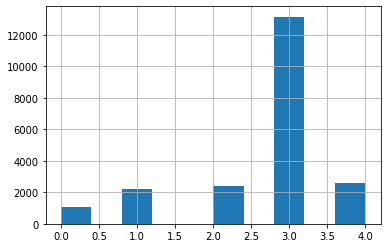

In [4]:
train_csv.label.hist()

In [5]:
train_csv.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

What can we do?

 - Upsampling: insert repeated data to classes with less samples up to the maximum number (in this case 13158). If we do that, we would need to use data augmentation in order to not fall into overfitting problem.

#  Display the images

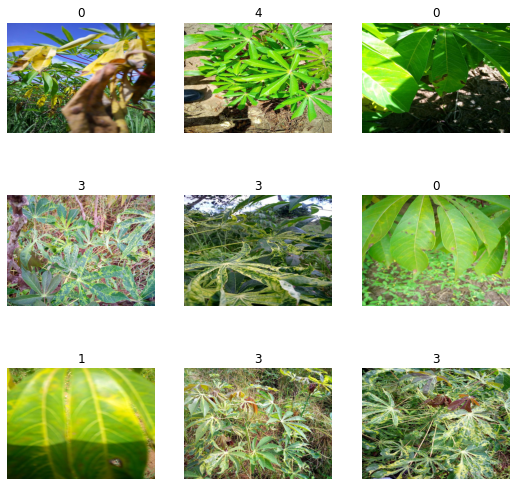

In [6]:
row, col = 3, 3
fig = plt.figure(figsize=(3*col, 3*row))
for r in range(row):
    for c in range(col):
        ax = plt.subplot(row, col, r*col + c + 1)
        ix = random.randint(0, len(train_csv)-1)
        img = torchvision.io.read_image(str(path + 'train_images/' + train_csv['image_id'][ix]))
        label = train_csv['label'][ix]
        plt.axis('off')
        plt.imshow(img.permute(1,2,0))
        plt.title(label)
plt.show()

In [7]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader

class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, imgs, labels, transform=None):
        self.imgs = imgs
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, ix):
        img = torchvision.io.read_image(self.imgs[ix]).float() / 255.
        label = torch.tensor(self.labels[ix], dtype = torch.long)
        if self.transform:
            img = self.transform(img)
        return img, label
        
    
class DataModule(pl.LightningDataModule):

    def __init__(self, path, img_size = (512,512), batch_size=16, test_size = 0.2, random_state = 42, subset = 0.1):
        super().__init__()
        self.path = path
        self.batch_size = batch_size
        self.random_state = random_state
        self.test_size = test_size
        self.subset = subset
        self.img_size = img_size

    def setup(self, stage=None):
        df = pd.read_csv(self.path + 'train.csv')
        train, val = sklearn.model_selection.train_test_split(
            df,
            test_size = self.test_size,
            shuffle = True,
            stratify = df['label'],
            random_state = self.random_state)
        print('Training samples: ',len(train))
        print('Validation samples: ',len(val))
        
        if self.subset:
            _ , subset = sklearn.model_selection.train_test_split(
            train,
            test_size = self.subset,
            shuffle = True,
            stratify = train['label'],
            random_state = self.random_state) 
            
            print('Training  with', len(subset), 'images')
            train_imgs = [path + 'train_images/'+img for img in subset['image_id'].values]
            train_labels = subset['label'].values
            
        else:
            train_imgs = [path + 'train_images/' + img for img in train['image_id'].values]
            train_labels = train['label'].values
            
        self.train_ds = Dataset(train_imgs, train_labels)
        
        val_imgs = [path + 'train_images/' + img for img in val['image_id'].values]
        print(val_imgs)
        val_labels = val['label'].values
        self.val_ds = Dataset(val_imgs, val_labels)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle = True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle = False)


In [8]:
dm = DataModule(path)
dm.setup()

Training samples:  17117
Validation samples:  4280
Training  with 1712 images
['/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/train_images/288080098.jpg', '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/train_images/3080364100.jpg', '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/train_images/110051175.jpg', '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/train_images/2612067247.jpg', '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/train_images/3852927202.jpg', '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/train_images/4218669271.jpg', '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/train_images/2509869422.jpg', '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/train_images/212727951.jpg', '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/train_images/2406905705.jpg', '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/train_images/706806140.jpg', '/media/sergio/traballos 

In [10]:
dm.val_dataloader[0]

TypeError: 'method' object is not subscriptable

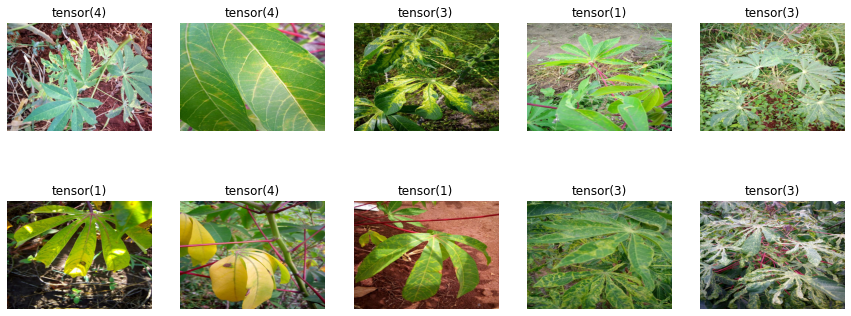

In [13]:
row, col = 2, 5
fig = plt.figure(figsize=(3*col, 3*row))
ds = dm.train_ds
for r in range(row):
    for c in range(col):
        ax = plt.subplot(row, col, r*col + c + 1)
        ix = random.randint(0, len(ds)-1)
        img , label = ds[ix]
        plt.axis('off')
        plt.imshow(img.permute(1,2,0))
        plt.title(label)
plt.show()